# Simulate GRBs with correlations

In [1]:
%env NUMEXPR_MAX_THREADS=16
%env OMP_NUM_THREADS=1
%env MKL_NUM_THREADS=1
%env NUMEXPR_NUM_THREADS=1
%env DISPLAY=:0.0

env: NUMEXPR_MAX_THREADS=16
env: OMP_NUM_THREADS=1
env: MKL_NUM_THREADS=1
env: NUMEXPR_NUM_THREADS=1
env: DISPLAY=:0.0


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

import popsynth
from popsynth.aux_samplers.trunc_normal_aux_sampler import TruncatedNormalAuxSampler
from popsynth.aux_samplers.lognormal_aux_sampler import LogNormalAuxSampler
from zusammen.synthetic_populations.aux_samplers import TDecaySampler, DurationSampler, LumSampler, EpeakObsSampler
%matplotlib notebook
import cosmogrb

/Users/fran/.virtualenvs/grb/lib/python3.8/site-packages/popsynth/distribution.py:8: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm as progress_bar


Configuration read from /Users/fran/.threeML/threeML_config.yml


## Simulate population

In [3]:
pop_gen = popsynth.populations.SFRPopulation(r0=1./15, rise=1., decay=4.0,
                                             peak=1.5, r_max=7.0)

t90 = LogNormalAuxSampler(name="log_t90", observed=False)
t90.mu=10
t90.tau=0.1

log_ep = LogNormalAuxSampler(name="log_ep", observed=False)
log_ep.mu=300
log_ep.tau=0.2

alpha = TruncatedNormalAuxSampler(name="alpha", observed=False)
alpha.lower=-1.5
alpha.upper=0.0
alpha.mu=-0.6
alpha.tau=0.1

ep_tau = TruncatedNormalAuxSampler(name="ep_tau", observed=False)
ep_tau.lower=-2
ep_tau.upper=-1
ep_tau.mu=-1.2
ep_tau.tau=0.1

log_nrest = LogNormalAuxSampler(name="log_nrest", observed=False)
log_nrest.mu = 2e51
log_nrest.tau = 0.1

gamma = TruncatedNormalAuxSampler(name="gamma", observed=False)
gamma.mu = 1.5
gamma.tau = 0.2
gamma.lower = 1.0
gamma.upper = 2.0

duration = DurationSampler()
obs_lum = LumSampler()
log_ep_obs = EpeakObsSampler()

duration.set_secondary_sampler(t90)
obs_lum.set_secondary_sampler(log_ep)
obs_lum.set_secondary_sampler(log_nrest)
obs_lum.set_secondary_sampler(gamma)
log_ep_obs.set_secondary_sampler(log_ep)

pop_gen.add_observed_quantity(duration)
pop_gen.add_observed_quantity(obs_lum)
pop_gen.add_observed_quantity(log_ep_obs)
pop_gen.add_observed_quantity(alpha)
pop_gen.add_observed_quantity(ep_tau)

registering auxilary sampler: duration
registering derived luminosity sampler: obs_lum
registering auxilary sampler: log_ep_obs
registering auxilary sampler: alpha
registering auxilary sampler: ep_tau


In [4]:
population = pop_gen.draw_survey(no_selection=True, boundary=1e-2, flux_sigma=0.0, 
                                 verbose=False)
population.writeto("data/grb_pop.h5")
print("N =", len(population.distances))

No Selection! Added back all objects
N = 2


### Show population properties

In [5]:
population.alpha

array([-0.8469555 , -0.57012314])

<IPython.core.display.Javascript object>


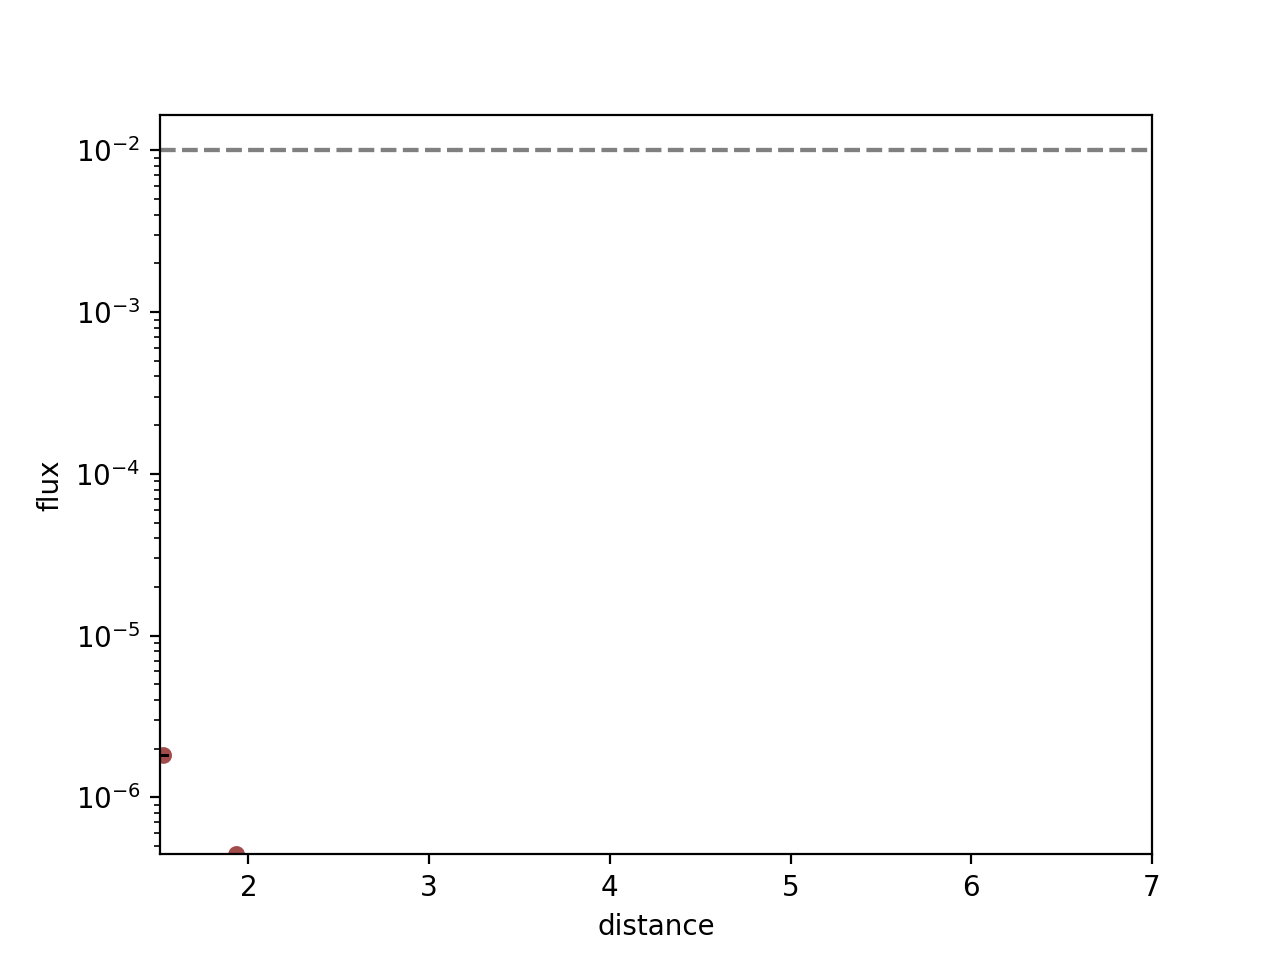

In [6]:
population.display_fluxes();

## Simulate detection

In [7]:
from dask.distributed import LocalCluster, Client

from corr_cpl.corr_cpl_universe import GBM_CORR_CPL_Universe
from cosmogrb.universe.survey import Survey

In [8]:
cluster = LocalCluster(n_workers=8)
client = Client(cluster)
client

Client Scheduler: tcp://127.0.0.1:55797 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 8 Cores: 16 Memory: 34.36 GB


In [9]:
universe = GBM_CORR_CPL_Universe('data/grb_pop.h5', save_path="data")

universe.go(client)

universe.save('data/grb_pop_survey.h5')

In [10]:
survey = Survey.from_file('data/grb_pop_survey.h5')
survey.info()

,0
n_grbs,2
is_processed,False


## Run trigger algorithm

In [11]:
from cosmogrb.instruments.gbm.gbm_trigger import GBMTrigger

In [12]:
survey.process(GBMTrigger, client=client, threshold=4.5)
survey.write('data/grb_pop_survey.h5')

In [13]:
survey = Survey.from_file('data/grb_pop_survey.h5')
survey.info()

,0
n_grbs,2
is_processed,True
n_detected,2


In [14]:
client.close()
cluster.close()

distributed.nanny - WARNING - Worker process still alive after 3 seconds, killing
distributed.nanny - WARNING - Worker process still alive after 3 seconds, killing


In [15]:
name = "SynthGRB_0"
survey[name].detector_info.info()

,0
name,SynthGRB_0
is_detected,True


,0
triggered_detectors,"[b'n0', b'n2']"
triggered_time_scales,"[0.016, 0.016]"
triggered_times,"[3.339550858072471e-11, 3.339550858072471e-11]"


## Plot detected grbs

<IPython.core.display.Javascript object>


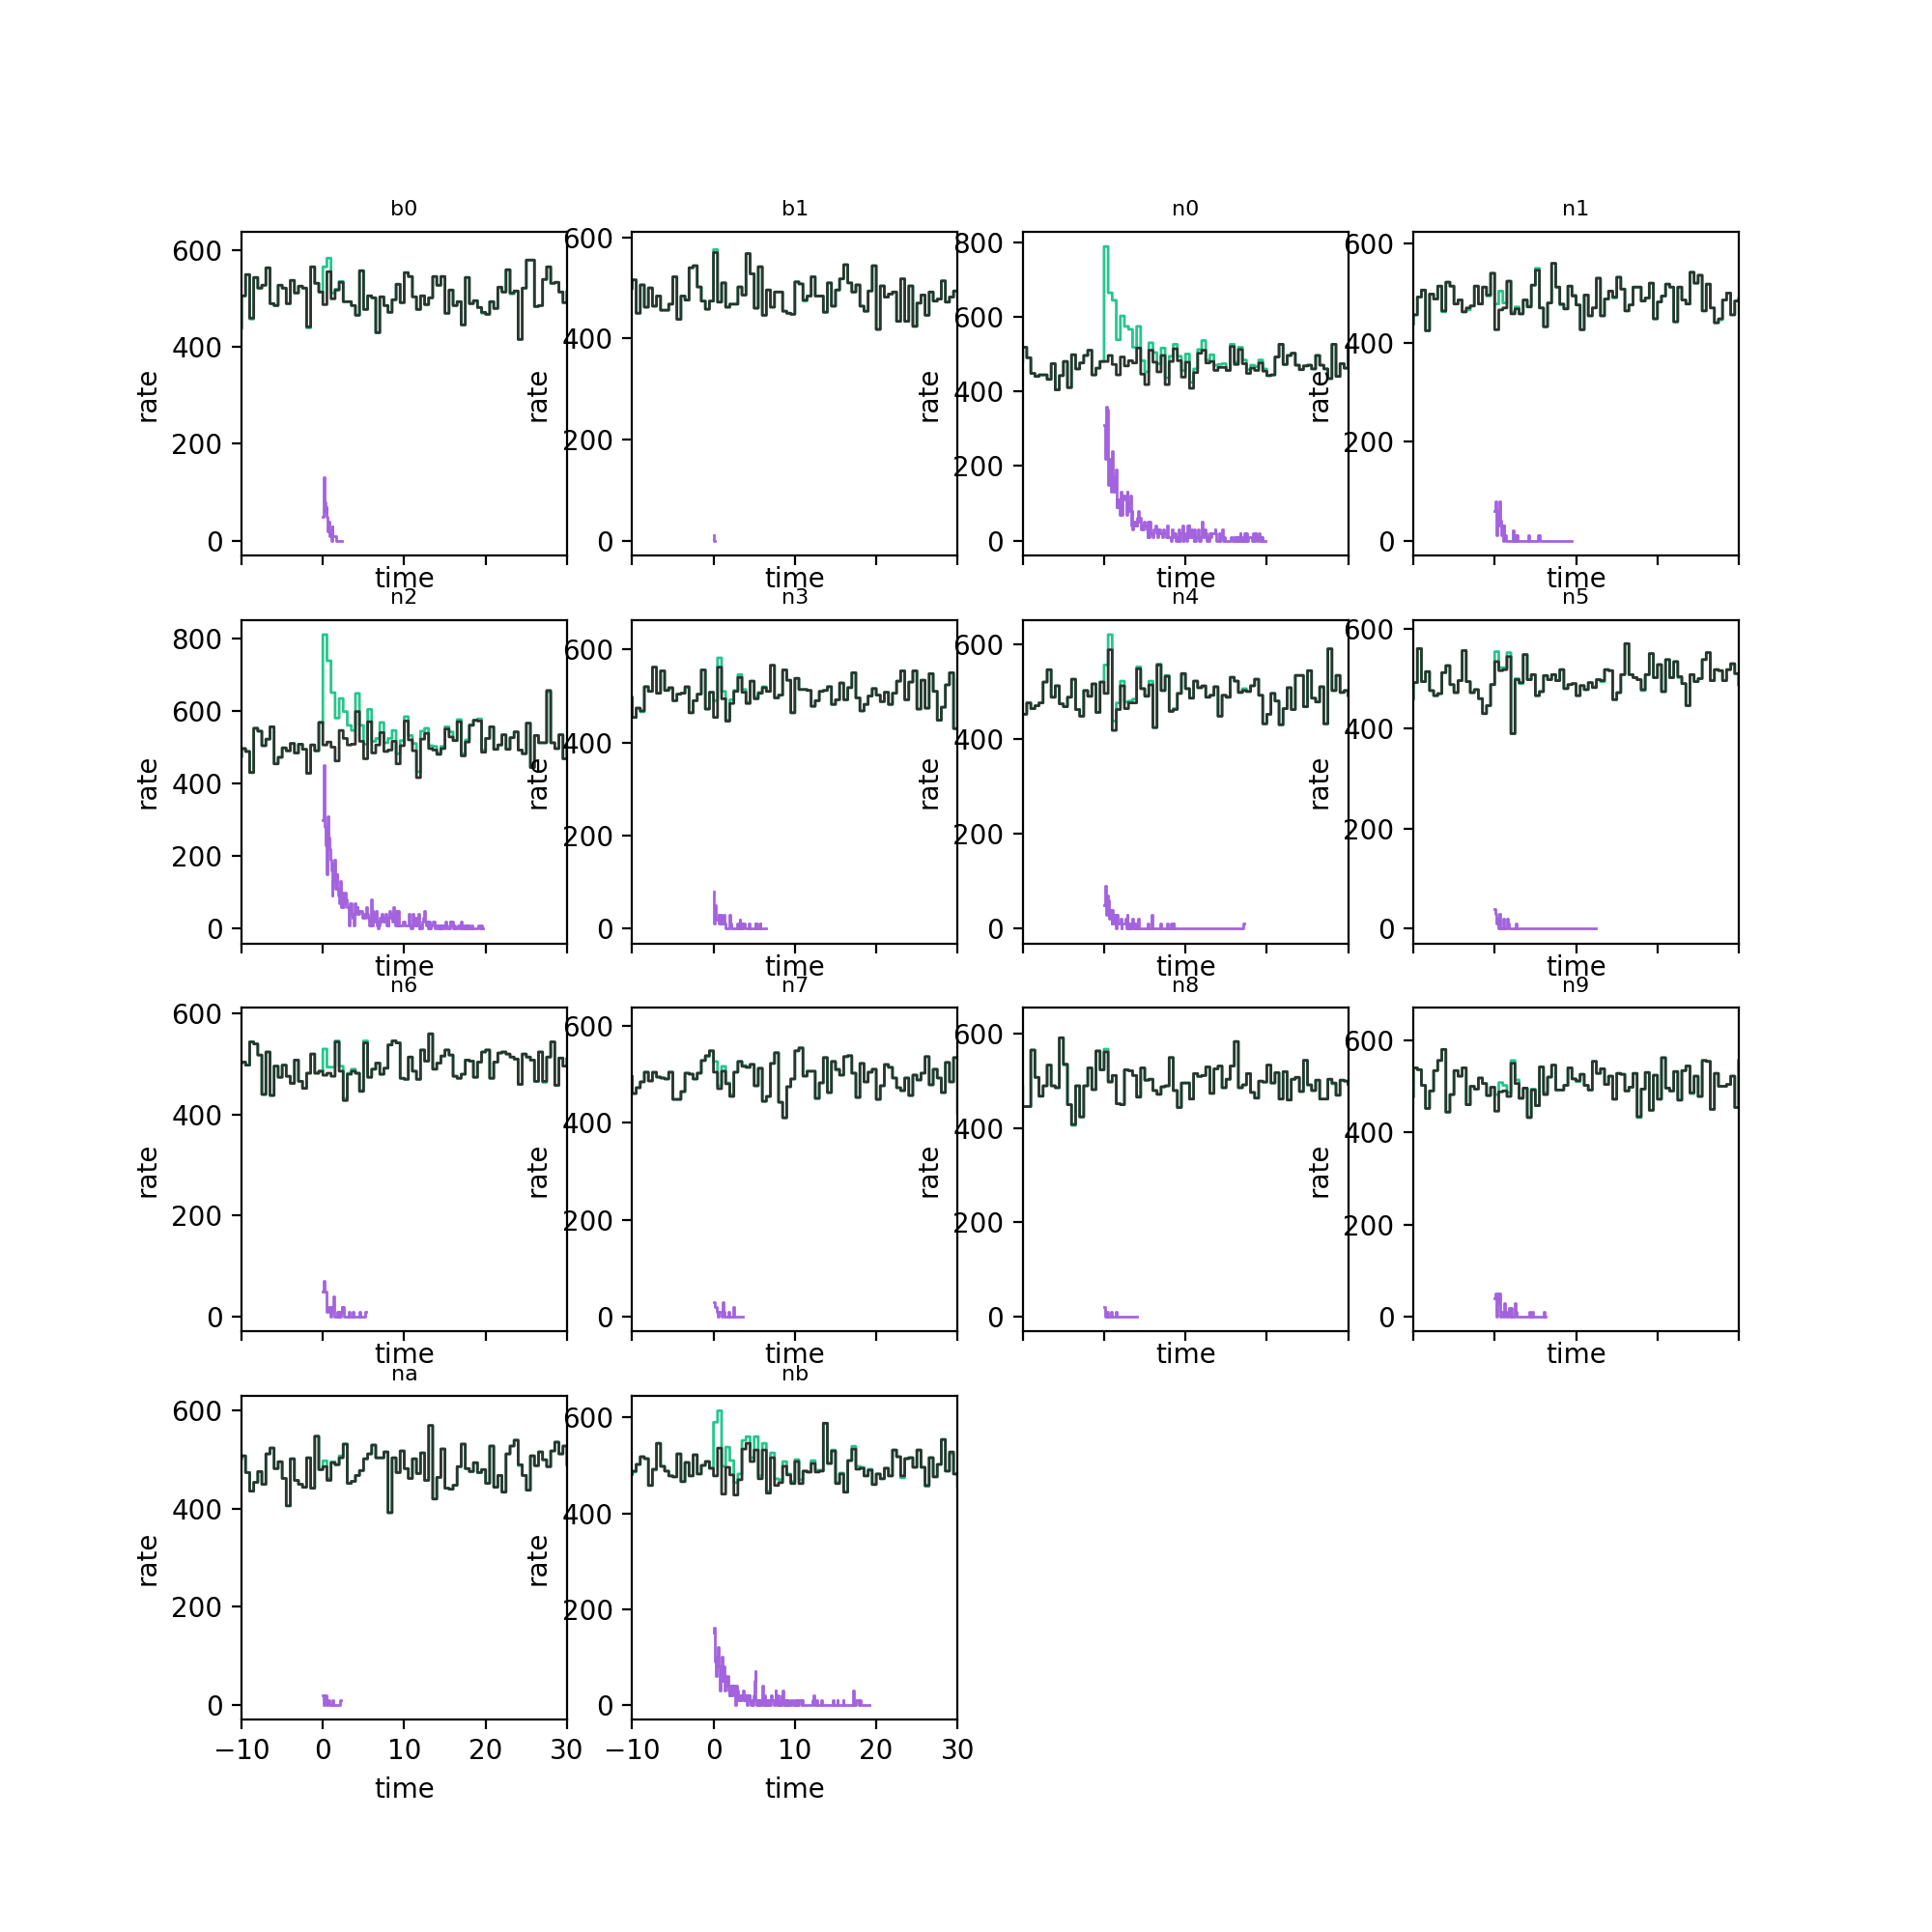

In [16]:
fig, axes = plt.subplots(4,4,sharex=True,sharey=False,figsize=(10,10))
row=0
col = 0
for k,v  in survey[name].grb.items():
    ax = axes[row][col]

    lightcurve =v['lightcurve']

    lightcurve.display_lightcurve(dt=.5, ax=ax,lw=1,color='#25C68C')
    lightcurve.display_source(dt=0.1,ax=ax,lw=1,color="#A363DE")
    lightcurve.display_background(dt=.5,ax=ax,lw=1, color="#2C342E")
    ax.set_xlim(-10, 30)
    ax.set_title(k,size=8)

    if col < 3:
        col+=1
    else:
        row+=1
        col=0

axes[3,2].set_visible(False)
axes[3,3].set_visible(False)

In [17]:
survey[name].grb

name          SynthGRB_0
z                1.93525
ra               327.354
dec             -58.1829
duration         19.9148
T0                     0
Nrest        1.74528e+51
alpha          -0.846955
ep_start         155.692
ep_tau          -1.07661
gamma            1.53053
peak_flux    4.43823e-07